<a href="https://colab.research.google.com/github/daniruro19/TasadorCochesNet/blob/main/ruizDaniel_cochesnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Vamos a intentar a prededecir el precio de un coche. Usaremos los datos que hemos recopilado en *coches.net*. (Menos los de Jose)


#IMPORTACIONES DE LIBRERIAS

In [ ]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from keras.layers import Dense
import keras
from keras.models import Sequential
import tensorflow as tf

In [ ]:
import pandas as pd
import numpy as np

# upload files
from google.colab import files, drive
import io
import os

# formatos csv, json
import csv
import json

In [ ]:
drive.mount('/content/drive')
path = '/content/drive/MyDrive/IABD/cochesNET'

Mounted at /content/drive


#LIMPIEZA Y PROCESADO DE LOS DIFERENTES DATASETS

In [ ]:
#Definimos las columnas que queremos en el dataset combinado de todos los json y csv
df_cols = [
  'url',
  'color',
  'fuelType',
  'km',
  'make',
  'model',
  'price',
  'province',
  'title',
  'transmissionType',
  'year',
  'seller_type',
  'bodyType',
  'cubicCapacity',
  'doors',
  'hp',
]

In [ ]:
# Creamos un df vacio con las columnas deseadas y obtenemos los json 
data = pd.DataFrame(columns=df_cols)
json_files = [json for json in os.listdir(path) if '.json' in json]

# recorremos los ficheros
for filename in json_files:
  # cargamos el contenido del fichero y eliminamos la columna datetime
  df = pd.read_json(path + '/' + filename).drop('datetime', axis=1)
  
  # Si el JSON posee 'resto_de_datos' metemos todas las columnas de dentro en el dataset principal 
  try:
    resto_de_datos = pd.json_normalize(df['resto_de_datos']).drop('url', axis=1) # Aqui eliminamos tambien la columna duplicada url de resto_de_datos
    df = df.drop('resto_de_datos', axis=1)
    df = pd.concat([df, resto_de_datos],  axis=1)
  except KeyError:
    pass
    
  # eliminamos las columnas con ID y columnas duplicadas o irrelevantes
  columnas_eliminar = ['id','brand', 'brand_id', 'fuelTypeId', 'makeId','modelId','provinceId','transmissionTypeId','model_id', 'fuelTypeId', 'fuel_types']
  df = df.drop(columnas_eliminar, axis=1)

  # Añadimos los datos al Dataset principal
  data = pd.concat([data, df])

data

,url,color,fuelType,km,make,model,price,province,title,transmissionType,year,seller_type,bodyType,cubicCapacity,doors,hp,hola,aaa
0,https://www.coches.net/volkswagen-golf-sport-1...,COMMON.COLOR_WHITE,Diésel,180000,VOLKSWAGEN,Golf,13990,Guipúzcoa,VOLKSWAGEN Golf Sport 1.6 TDI 110CV BMT DSG 5p.,COMMON.TRANSMISSION_AUTOMATIC,2016,particular,BODY_TYPE_SEDAN,1598.0,5,110.0,NaN,NaN
1,https://www.coches.net/volkswagen-multivan-pre...,COMMON.COLOR_WHITE,Diésel,34000,VOLKSWAGEN,Multivan,68000,A Coruña,VOLKSWAGEN Multivan Premium Corto 2.0 TDI 110k...,COMMON.TRANSMISSION_MANUAL,2020,particular,BODY_TYPE_MINIVAN,1968.0,5,150.0,NaN,NaN
2,https://www.coches.net/volkswagen-caravelle-or...,COMMON.COLOR_RED,Diésel,70000,VOLKSWAGEN,Caravelle,36900,Asturias,VOLKSWAGEN Caravelle Origin Corta 2.0 TDI 110k...,COMMON.TRANSMISSION_AUTOMATIC,2021,profesional,BODY_TYPE_MINIVAN,1968.0,4,150.0,NaN,NaN
3,https://www.coches.net/volkswagen-tiguan-sport...,COMMON.COLOR_GRAY,Diésel,66855,VOLKSWAGEN,Tiguan,33500,Madrid,VOLKSWAGEN Tiguan Sport 2.0 TDI 110kW 150CV DS...,COMMON.TRANSMISSION_AUTOMATIC,2019,profesional,BODY_TYPE_4X4,1968.0,5,150.0,NaN,NaN
4,https://www.coches.net/volkswagen-polo-gti-18-...,COMMON.COLOR_WHITE,Gasolina,89000,VOLKSWAGEN,Polo,16500,Barcelona,VOLKSWAGEN Polo GTI 1.8 TSI 192cv 3p.,COMMON.TRANSMISSION_MANUAL,2015,profesional,BODY_TYPE_SEDAN,1798.0,3,192.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828,https://www.coches.net/skoda-rapid-16-tdi-cr-1...,COMMON.COLOR_WHITE,Diésel,92000,SKODA,Rapid,9950,Las Palmas,SKODA Rapid 1.6 TDI CR 105cv Active 5p.,COMMON.TRANSMISSION_MANUAL,2013,profesional,BODY_TYPE_SEDAN,1598.0,5,105.0,NaN,NaN
829,https://www.coches.net/skoda-fabia-12-60cv-spi...,COMMON.COLOR_WHITE,Gasolina,56000,SKODA,Fabia,7499,Madrid,SKODA Fabia 1.2 60cv Spirit 5p.,COMMON.TRANSMISSION_MANUAL,2013,profesional,BODY_TYPE_SEDAN,1198.0,5,60.0,NaN,NaN
830,https://www.coches.net/skoda-karoq-20-tdi-110k...,COMMON.COLOR_RED,Diésel,28500,SKODA,Karoq,28900,Córdoba,SKODA Karoq 2.0 TDI 110kW 150CV Ambition 5p.,COMMON.TRANSMISSION_MANUAL,2022,profesional,BODY_TYPE_4X4,1968.0,5,150.0,NaN,NaN
831,https://www.coches.net/skoda-octavia-combi-16-...,COMMON.COLOR_GRAY,Diésel,111000,SKODA,Octavia,14450,Madrid,SKODA Octavia Combi 1.6 TDI CR 85KW 115CV Acti...,COMMON.TRANSMISSION_MANUAL,2019,profesional,BODY_TYPE_FAMILIAR,1598.0,5,115.0,NaN,NaN


In [ ]:
# Eliminamos los duplicados de la url dado que la url es un identidicador inequivoco de un vehiculo
data = data.drop_duplicates(subset=['url'])

#Tratamiento de ciertas columnas 
data['color'] = data['color'].str.replace('COMMON.COLOR_', '')
data['transmissionType'] = data['transmissionType'].str.replace('COMMON.TRANSMISSION_', '')
data['bodyType'] = data['bodyType'].str.replace('BODY_TYPE_', '')

data

<ipython-input-6-52ba11b4ff42>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  data['color'] = data['color'].str.replace('COMMON.COLOR_', '')
<ipython-input-6-52ba11b4ff42>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['color'] = data['color'].str.replace('COMMON.COLOR_', '')
<ipython-input-6-52ba11b4ff42>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  data['transmissionType'] = data['transmissionType'].str.replace('COMMON.TRANSMISSION_', '')
<ipython-input-6-52ba11b4ff42>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

,url,color,fuelType,km,make,model,price,province,title,transmissionType,year,seller_type,bodyType,cubicCapacity,doors,hp,hola,aaa
0,https://www.coches.net/volkswagen-golf-sport-1...,WHITE,Diésel,180000,VOLKSWAGEN,Golf,13990,Guipúzcoa,VOLKSWAGEN Golf Sport 1.6 TDI 110CV BMT DSG 5p.,AUTOMATIC,2016,particular,SEDAN,1598.0,5,110.0,NaN,NaN
1,https://www.coches.net/volkswagen-multivan-pre...,WHITE,Diésel,34000,VOLKSWAGEN,Multivan,68000,A Coruña,VOLKSWAGEN Multivan Premium Corto 2.0 TDI 110k...,MANUAL,2020,particular,MINIVAN,1968.0,5,150.0,NaN,NaN
2,https://www.coches.net/volkswagen-caravelle-or...,RED,Diésel,70000,VOLKSWAGEN,Caravelle,36900,Asturias,VOLKSWAGEN Caravelle Origin Corta 2.0 TDI 110k...,AUTOMATIC,2021,profesional,MINIVAN,1968.0,4,150.0,NaN,NaN
3,https://www.coches.net/volkswagen-tiguan-sport...,GRAY,Diésel,66855,VOLKSWAGEN,Tiguan,33500,Madrid,VOLKSWAGEN Tiguan Sport 2.0 TDI 110kW 150CV DS...,AUTOMATIC,2019,profesional,4X4,1968.0,5,150.0,NaN,NaN
4,https://www.coches.net/volkswagen-polo-gti-18-...,WHITE,Gasolina,89000,VOLKSWAGEN,Polo,16500,Barcelona,VOLKSWAGEN Polo GTI 1.8 TSI 192cv 3p.,MANUAL,2015,profesional,SEDAN,1798.0,3,192.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828,https://www.coches.net/skoda-rapid-16-tdi-cr-1...,WHITE,Diésel,92000,SKODA,Rapid,9950,Las Palmas,SKODA Rapid 1.6 TDI CR 105cv Active 5p.,MANUAL,2013,profesional,SEDAN,1598.0,5,105.0,NaN,NaN
829,https://www.coches.net/skoda-fabia-12-60cv-spi...,WHITE,Gasolina,56000,SKODA,Fabia,7499,Madrid,SKODA Fabia 1.2 60cv Spirit 5p.,MANUAL,2013,profesional,SEDAN,1198.0,5,60.0,NaN,NaN
830,https://www.coches.net/skoda-karoq-20-tdi-110k...,RED,Diésel,28500,SKODA,Karoq,28900,Córdoba,SKODA Karoq 2.0 TDI 110kW 150CV Ambition 5p.,MANUAL,2022,profesional,4X4,1968.0,5,150.0,NaN,NaN
831,https://www.coches.net/skoda-octavia-combi-16-...,GRAY,Diésel,111000,SKODA,Octavia,14450,Madrid,SKODA Octavia Combi 1.6 TDI CR 85KW 115CV Acti...,MANUAL,2019,profesional,FAMILIAR,1598.0,5,115.0,NaN,NaN


In [ ]:
# Ahora hacemos lo mismo con los CSV
columnas_eliminar = [
  'id',
  'makeId',
  'modelId',
  'provinceId',
  'transmissionTypeId',
  'fuelTypeId',
]

In [ ]:
csv_files = [csv for csv in os.listdir(path) if '.csv' in csv]
for filename in csv_files:
  df = pd.read_csv(path + '/' + filename).drop(columnas_eliminar, axis=1)

  # renombramos la columna body_types para poder concatenarla con bodyType del resto de ficheros
  try:
    df = df.rename(columns={'body_types':'bodyType'})
  except KeyError:
    pass

  #Eliminamos las columnas una a una dado la heterogeneidad de los ficheros (columnas que puede que esten en un fichero pero en otro no)
  columnas_eliminar_unicas = ['fecha', 'date', 'Unnamed: 0', 'seller_type_id', 'body_types_id', 'publicationDate','hola','aaa'] #eliminamos fechas, columnas id y columnas irrelevantes
  for col in columnas_eliminar_unicas:
    try:
      df = df.drop(col, axis=1)
    except KeyError:
      pass
  
  data = pd.concat([data, df])

data

,url,color,fuelType,km,make,model,price,province,title,transmissionType,year,seller_type,bodyType,cubicCapacity,doors,hp,hola,aaa
0,https://www.coches.net/volkswagen-golf-sport-1...,WHITE,Diésel,180000,VOLKSWAGEN,Golf,13990,Guipúzcoa,VOLKSWAGEN Golf Sport 1.6 TDI 110CV BMT DSG 5p.,AUTOMATIC,2016,particular,SEDAN,1598.0,5,110.0,NaN,NaN
1,https://www.coches.net/volkswagen-multivan-pre...,WHITE,Diésel,34000,VOLKSWAGEN,Multivan,68000,A Coruña,VOLKSWAGEN Multivan Premium Corto 2.0 TDI 110k...,MANUAL,2020,particular,MINIVAN,1968.0,5,150.0,NaN,NaN
2,https://www.coches.net/volkswagen-caravelle-or...,RED,Diésel,70000,VOLKSWAGEN,Caravelle,36900,Asturias,VOLKSWAGEN Caravelle Origin Corta 2.0 TDI 110k...,AUTOMATIC,2021,profesional,MINIVAN,1968.0,4,150.0,NaN,NaN
3,https://www.coches.net/volkswagen-tiguan-sport...,GRAY,Diésel,66855,VOLKSWAGEN,Tiguan,33500,Madrid,VOLKSWAGEN Tiguan Sport 2.0 TDI 110kW 150CV DS...,AUTOMATIC,2019,profesional,4X4,1968.0,5,150.0,NaN,NaN
4,https://www.coches.net/volkswagen-polo-gti-18-...,WHITE,Gasolina,89000,VOLKSWAGEN,Polo,16500,Barcelona,VOLKSWAGEN Polo GTI 1.8 TSI 192cv 3p.,MANUAL,2015,profesional,SEDAN,1798.0,3,192.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009,https://www.coches.net/mazda-cx5-22-d-110kw-15...,COMMON.COLOR_RED,Diésel,69000.0,MAZDA,CX5,24999.0,Madrid,MAZDA CX5 2.2 D 110kW 150CV 2WD AT Zenith,COMMON.TRANSMISSION_AUTOMATIC,2019.0,profesional,4x4 suv,2191.0,5.0,150.0,NaN,NaN
2010,https://www.coches.net/mazda-mx5-20-118kw-160c...,COMMON.COLOR_WHITE,Gasolina,63912.0,MAZDA,MX5,19400.0,Madrid,MAZDA MX5 2.0 118kW 160CV Style 2p.,COMMON.TRANSMISSION_MANUAL,2016.0,profesional,cabrio,1998.0,2.0,160.0,NaN,NaN
2011,https://www.coches.net/mazda-mazda2-gasolina-2...,COMMON.COLOR_BLUE,Gasolina,47000.0,MAZDA,Mazda2,10500.0,Barcelona,MAZDA Mazda2,COMMON.TRANSMISSION_MANUAL,2015.0,particular,NaN,NaN,5.0,NaN,NaN,NaN
2012,https://www.coches.net/mazda-cx5-22-110kw-150c...,COMMON.COLOR_GRAY,Diésel,79000.0,MAZDA,CX5,17400.0,Castellón,MAZDA CX5 2.2 110kW 150CV DE 2WD AT Style 5p.,COMMON.TRANSMISSION_AUTOMATIC,2015.0,profesional,4x4 suv,2191.0,5.0,150.0,NaN,NaN


In [ ]:
#Quitamos las columnas hola y aaa que se quedaron
data=data.drop("aaa", axis=1)
data=data.drop("hola", axis=1)

In [ ]:
data

,url,color,fuelType,km,make,model,price,province,title,transmissionType,year,seller_type,bodyType,cubicCapacity,doors,hp
0,https://www.coches.net/volkswagen-golf-sport-1...,WHITE,Diésel,180000,VOLKSWAGEN,Golf,13990,Guipúzcoa,VOLKSWAGEN Golf Sport 1.6 TDI 110CV BMT DSG 5p.,AUTOMATIC,2016,particular,SEDAN,1598.0,5,110.0
1,https://www.coches.net/volkswagen-multivan-pre...,WHITE,Diésel,34000,VOLKSWAGEN,Multivan,68000,A Coruña,VOLKSWAGEN Multivan Premium Corto 2.0 TDI 110k...,MANUAL,2020,particular,MINIVAN,1968.0,5,150.0
2,https://www.coches.net/volkswagen-caravelle-or...,RED,Diésel,70000,VOLKSWAGEN,Caravelle,36900,Asturias,VOLKSWAGEN Caravelle Origin Corta 2.0 TDI 110k...,AUTOMATIC,2021,profesional,MINIVAN,1968.0,4,150.0
3,https://www.coches.net/volkswagen-tiguan-sport...,GRAY,Diésel,66855,VOLKSWAGEN,Tiguan,33500,Madrid,VOLKSWAGEN Tiguan Sport 2.0 TDI 110kW 150CV DS...,AUTOMATIC,2019,profesional,4X4,1968.0,5,150.0
4,https://www.coches.net/volkswagen-polo-gti-18-...,WHITE,Gasolina,89000,VOLKSWAGEN,Polo,16500,Barcelona,VOLKSWAGEN Polo GTI 1.8 TSI 192cv 3p.,MANUAL,2015,profesional,SEDAN,1798.0,3,192.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009,https://www.coches.net/mazda-cx5-22-d-110kw-15...,COMMON.COLOR_RED,Diésel,69000.0,MAZDA,CX5,24999.0,Madrid,MAZDA CX5 2.2 D 110kW 150CV 2WD AT Zenith,COMMON.TRANSMISSION_AUTOMATIC,2019.0,profesional,4x4 suv,2191.0,5.0,150.0
2010,https://www.coches.net/mazda-mx5-20-118kw-160c...,COMMON.COLOR_WHITE,Gasolina,63912.0,MAZDA,MX5,19400.0,Madrid,MAZDA MX5 2.0 118kW 160CV Style 2p.,COMMON.TRANSMISSION_MANUAL,2016.0,profesional,cabrio,1998.0,2.0,160.0
2011,https://www.coches.net/mazda-mazda2-gasolina-2...,COMMON.COLOR_BLUE,Gasolina,47000.0,MAZDA,Mazda2,10500.0,Barcelona,MAZDA Mazda2,COMMON.TRANSMISSION_MANUAL,2015.0,particular,NaN,NaN,5.0,NaN
2012,https://www.coches.net/mazda-cx5-22-110kw-150c...,COMMON.COLOR_GRAY,Diésel,79000.0,MAZDA,CX5,17400.0,Castellón,MAZDA CX5 2.2 110kW 150CV DE 2WD AT Style 5p.,COMMON.TRANSMISSION_AUTOMATIC,2015.0,profesional,4x4 suv,2191.0,5.0,150.0


In [ ]:
#funciones para la obtención de columnas con valores nulos
def columns_without_values(data):
    columns = data.isnull().sum()
    print(columns[columns > 0])

#funciones para obtener la representación de los diagramas de cajas
def draw_hist_boxplot(df, feature_name):
    sns.boxplot(x=feature_name, data=df)
    sns.stripplot(x=feature_name, data=df, color="#474646")

#funciones que se utilizan para 'corregir' valores atípicos
def replace_outliers_with_median(df, feature_name):
    Q1 = df[feature_name].quantile(0.25)
    median = df[feature_name].quantile(0.5)
    Q3 = df[feature_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_whisker = Q1 - 1.5 * IQR
    upper_whisker = Q3 + 1.5 * IQR
    df[feature_name] = np.where((df[feature_name] < lower_whisker) | 
                                (df[feature_name] > upper_whisker), 
                                 median, 
                                 df[feature_name])

In [ ]:
columns_without_values(data)

url                   1
color                 9
fuelType              7
km                    7
make                  7
model                 7
price                 7
province              7
title                 7
transmissionType     10
year                  7
seller_type           7
bodyType            225
cubicCapacity       361
doors                17
hp                  231
dtype: int64


Obtener información acerca de los datos que se acaban de leer.

In [ ]:
type(data)

pandas.core.frame.DataFrame

In [ ]:
data.head()

,url,color,fuelType,km,make,model,price,province,title,transmissionType,year,seller_type,bodyType,cubicCapacity,doors,hp
0,https://www.coches.net/volkswagen-golf-sport-1...,WHITE,Diésel,180000,VOLKSWAGEN,Golf,13990,Guipúzcoa,VOLKSWAGEN Golf Sport 1.6 TDI 110CV BMT DSG 5p.,AUTOMATIC,2016,particular,SEDAN,1598.0,5,110.0
1,https://www.coches.net/volkswagen-multivan-pre...,WHITE,Diésel,34000,VOLKSWAGEN,Multivan,68000,A Coruña,VOLKSWAGEN Multivan Premium Corto 2.0 TDI 110k...,MANUAL,2020,particular,MINIVAN,1968.0,5,150.0
2,https://www.coches.net/volkswagen-caravelle-or...,RED,Diésel,70000,VOLKSWAGEN,Caravelle,36900,Asturias,VOLKSWAGEN Caravelle Origin Corta 2.0 TDI 110k...,AUTOMATIC,2021,profesional,MINIVAN,1968.0,4,150.0
3,https://www.coches.net/volkswagen-tiguan-sport...,GRAY,Diésel,66855,VOLKSWAGEN,Tiguan,33500,Madrid,VOLKSWAGEN Tiguan Sport 2.0 TDI 110kW 150CV DS...,AUTOMATIC,2019,profesional,4X4,1968.0,5,150.0
4,https://www.coches.net/volkswagen-polo-gti-18-...,WHITE,Gasolina,89000,VOLKSWAGEN,Polo,16500,Barcelona,VOLKSWAGEN Polo GTI 1.8 TSI 192cv 3p.,MANUAL,2015,profesional,SEDAN,1798.0,3,192.0


In [ ]:
data.dtypes

url                  object
color                object
fuelType             object
km                   object
make                 object
model                object
price                object
province             object
title                object
transmissionType     object
year                 object
seller_type          object
bodyType             object
cubicCapacity       float64
doors                object
hp                  float64
dtype: object

In [ ]:
#BORRAMOS LAS FILASCON LA MISMA URL
#eliminación de las filas en las que el valor objetivo es nulo
duplicates = data.duplicated(subset=['url'], keep='first')

# Select only the unique rows
data2 = data[~duplicates]

#Una vez hemos filtrado por url ya no tiene sentido seguir teniendolas
data2= data2.drop("url", axis=1)
data2= data2.drop("title", axis=1)

# Print the modified DataFrame
data2

,color,fuelType,km,make,model,price,province,transmissionType,year,seller_type,bodyType,cubicCapacity,doors,hp
0,WHITE,Diésel,180000,VOLKSWAGEN,Golf,13990,Guipúzcoa,AUTOMATIC,2016,particular,SEDAN,1598.0,5,110.0
1,WHITE,Diésel,34000,VOLKSWAGEN,Multivan,68000,A Coruña,MANUAL,2020,particular,MINIVAN,1968.0,5,150.0
2,RED,Diésel,70000,VOLKSWAGEN,Caravelle,36900,Asturias,AUTOMATIC,2021,profesional,MINIVAN,1968.0,4,150.0
3,GRAY,Diésel,66855,VOLKSWAGEN,Tiguan,33500,Madrid,AUTOMATIC,2019,profesional,4X4,1968.0,5,150.0
4,WHITE,Gasolina,89000,VOLKSWAGEN,Polo,16500,Barcelona,MANUAL,2015,profesional,SEDAN,1798.0,3,192.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009,COMMON.COLOR_RED,Diésel,69000.0,MAZDA,CX5,24999.0,Madrid,COMMON.TRANSMISSION_AUTOMATIC,2019.0,profesional,4x4 suv,2191.0,5.0,150.0
2010,COMMON.COLOR_WHITE,Gasolina,63912.0,MAZDA,MX5,19400.0,Madrid,COMMON.TRANSMISSION_MANUAL,2016.0,profesional,cabrio,1998.0,2.0,160.0
2011,COMMON.COLOR_BLUE,Gasolina,47000.0,MAZDA,Mazda2,10500.0,Barcelona,COMMON.TRANSMISSION_MANUAL,2015.0,particular,NaN,NaN,5.0,NaN
2012,COMMON.COLOR_GRAY,Diésel,79000.0,MAZDA,CX5,17400.0,Castellón,COMMON.TRANSMISSION_AUTOMATIC,2015.0,profesional,4x4 suv,2191.0,5.0,150.0


In [ ]:
#ELIMINAR VALORES NAN
#sustitución del valor nulo por el último valor de la misma columna
data2 = data2.fillna(method='ffill')
data2

,color,fuelType,km,make,model,price,province,transmissionType,year,seller_type,bodyType,cubicCapacity,doors,hp
0,WHITE,Diésel,180000.0,VOLKSWAGEN,Golf,13990.0,Guipúzcoa,AUTOMATIC,2016.0,particular,SEDAN,1598.0,5.0,110.0
1,WHITE,Diésel,34000.0,VOLKSWAGEN,Multivan,68000.0,A Coruña,MANUAL,2020.0,particular,MINIVAN,1968.0,5.0,150.0
2,RED,Diésel,70000.0,VOLKSWAGEN,Caravelle,36900.0,Asturias,AUTOMATIC,2021.0,profesional,MINIVAN,1968.0,4.0,150.0
3,GRAY,Diésel,66855.0,VOLKSWAGEN,Tiguan,33500.0,Madrid,AUTOMATIC,2019.0,profesional,4X4,1968.0,5.0,150.0
4,WHITE,Gasolina,89000.0,VOLKSWAGEN,Polo,16500.0,Barcelona,MANUAL,2015.0,profesional,SEDAN,1798.0,3.0,192.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009,COMMON.COLOR_RED,Diésel,69000.0,MAZDA,CX5,24999.0,Madrid,COMMON.TRANSMISSION_AUTOMATIC,2019.0,profesional,4x4 suv,2191.0,5.0,150.0
2010,COMMON.COLOR_WHITE,Gasolina,63912.0,MAZDA,MX5,19400.0,Madrid,COMMON.TRANSMISSION_MANUAL,2016.0,profesional,cabrio,1998.0,2.0,160.0
2011,COMMON.COLOR_BLUE,Gasolina,47000.0,MAZDA,Mazda2,10500.0,Barcelona,COMMON.TRANSMISSION_MANUAL,2015.0,particular,cabrio,1998.0,5.0,160.0
2012,COMMON.COLOR_GRAY,Diésel,79000.0,MAZDA,CX5,17400.0,Castellón,COMMON.TRANSMISSION_AUTOMATIC,2015.0,profesional,4x4 suv,2191.0,5.0,150.0


In [ ]:
columns_without_values(data2)

Series([], dtype: int64)


In [ ]:
campos_numericos = []

campos_categoricos = []
for columna in data2.columns:
    if data2[columna].dtype == 'int64' or data2[columna].dtype == 'float64':
        campos_numericos.append(columna)
    else:
        campos_categoricos.append(columna)
print('campos_numericos',campos_numericos)
campos_numericos.remove('price')
all_feature_names = campos_numericos + campos_categoricos

target = 'price' # o como se llame
all_feature_names
     

campos_numericos ['km', 'price', 'year', 'cubicCapacity', 'doors', 'hp']


['km',
 'year',
 'cubicCapacity',
 'doors',
 'hp',
 'color',
 'fuelType',
 'make',
 'model',
 'province',
 'transmissionType',
 'seller_type',
 'bodyType']

In [ ]:
print(data2[:10])

   color  fuelType        km        make      model    price    province  \
0  WHITE    Diésel  180000.0  VOLKSWAGEN       Golf  13990.0   Guipúzcoa   
1  WHITE    Diésel   34000.0  VOLKSWAGEN   Multivan  68000.0    A Coruña   
2    RED    Diésel   70000.0  VOLKSWAGEN  Caravelle  36900.0    Asturias   
3   GRAY    Diésel   66855.0  VOLKSWAGEN     Tiguan  33500.0      Madrid   
4  WHITE  Gasolina   89000.0  VOLKSWAGEN       Polo  16500.0   Barcelona   
5   GRAY    Diésel   76000.0  VOLKSWAGEN     Passat  18900.0      Toledo   
6   GRAY    Diésel   85341.0  VOLKSWAGEN       Golf  15990.0     Sevilla   
7   BLUE   Híbrido   64990.0  VOLKSWAGEN       Golf  23200.0      Madrid   
8   BLUE    Diésel  115000.0  VOLKSWAGEN     Passat  17500.0      Madrid   
9   GRAY    Diésel   49500.0  VOLKSWAGEN     Passat  22900.0  Las Palmas   

  transmissionType    year  seller_type  bodyType  cubicCapacity  doors     hp  
0        AUTOMATIC  2016.0   particular     SEDAN         1598.0    5.0  110.0  
1

#REPRESENTACIONES GRÁFICAS DE DATOS CATEGÓRICOS/NO CATEGÓRICOS

<ipython-input-64-542d36a014af>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data2[campos_numericos].hist(ax=plt.figure(figsize=(15,15)).gca())


array([[<Axes: title={'center': 'km'}>, <Axes: title={'center': 'year'}>],
       [<Axes: title={'center': 'cubicCapacity'}>,
        <Axes: title={'center': 'doors'}>],
       [<Axes: title={'center': 'hp'}>, <Axes: >]], dtype=object)

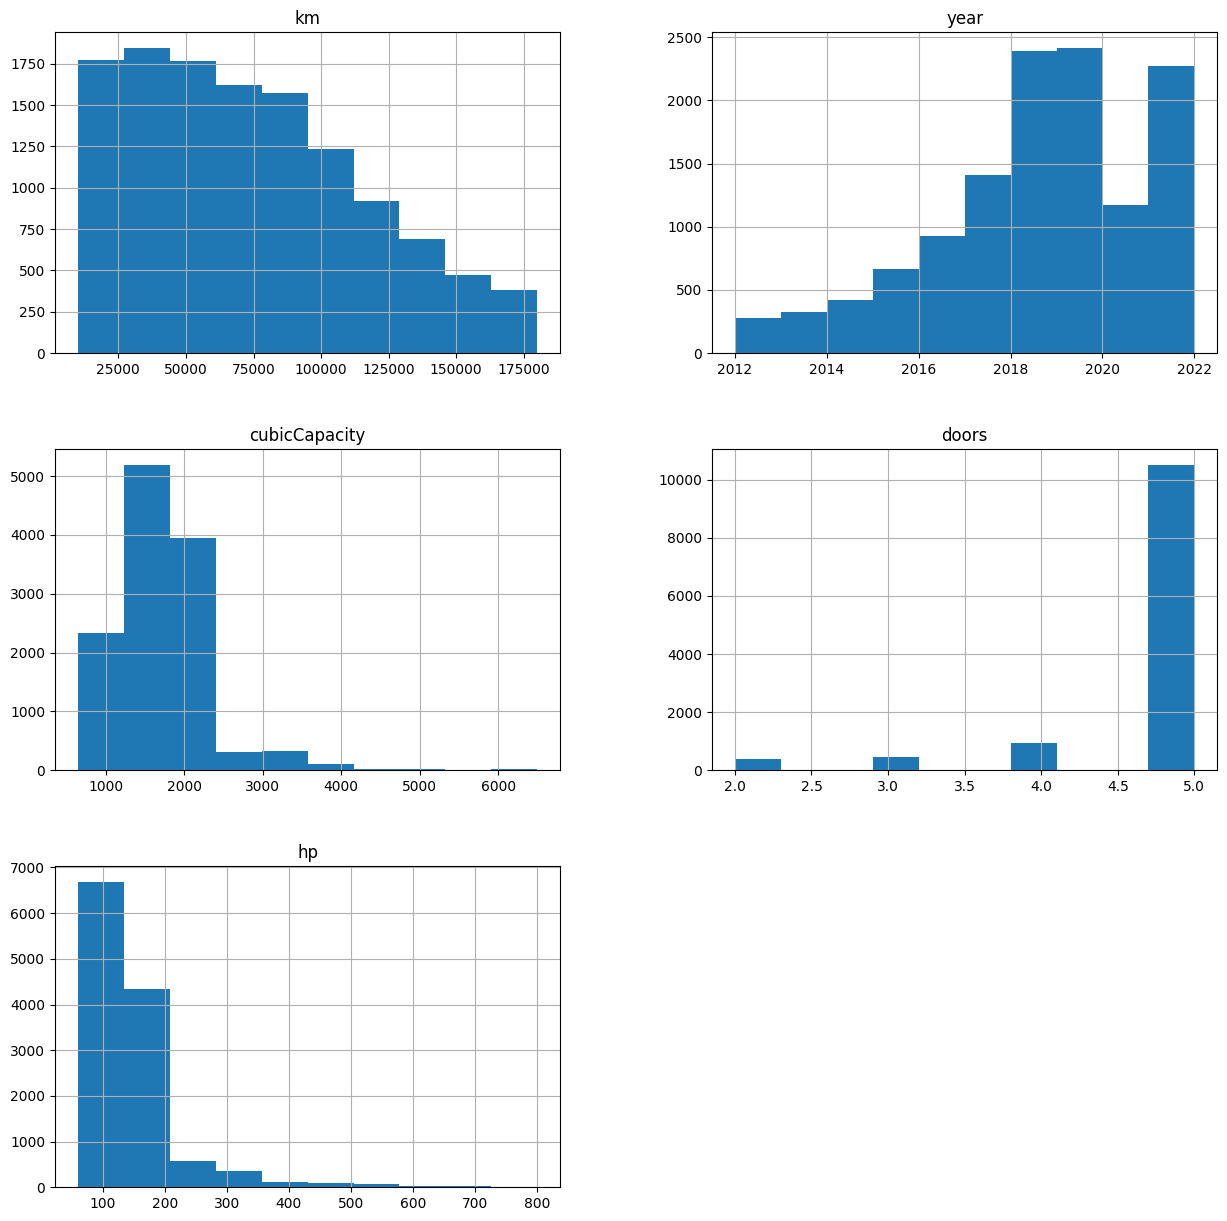

In [ ]:
import matplotlib.pyplot as plt
#histogramas de las columnas numéricas
data2[campos_numericos].hist(ax=plt.figure(figsize=(15,15)).gca())

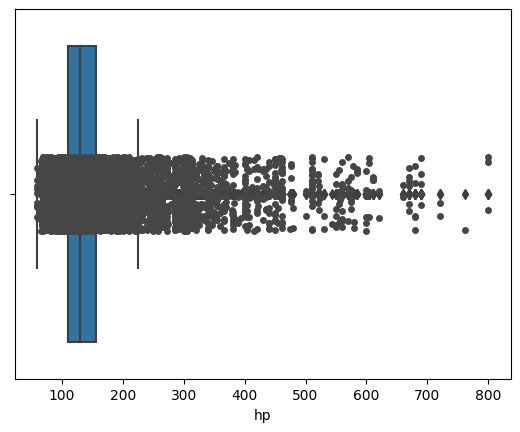

In [ ]:
import seaborn as sns
#visualizar los diagramas para todas las propiedades numéricas
draw_hist_boxplot(data2, 'hp')

In [ ]:
#Desviación de la distribución=> si el valor es negativo la desviación es a la izquierda y si es positivo es a la derecha
print(df['km'].skew())

0.47950902156396236


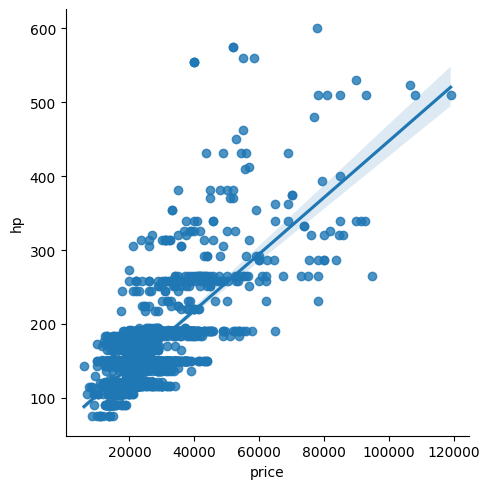

In [ ]:
sns.lmplot(data=df, x='price', y='hp', order=1)

<ipython-input-72-2c77a30bfac7>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data2[campos_numericos].hist(ax=plt.figure(figsize=(15,15)).gca())


array([[<Axes: title={'center': 'km'}>, <Axes: title={'center': 'year'}>],
       [<Axes: title={'center': 'cubicCapacity'}>,
        <Axes: title={'center': 'doors'}>],
       [<Axes: title={'center': 'hp'}>, <Axes: >]], dtype=object)

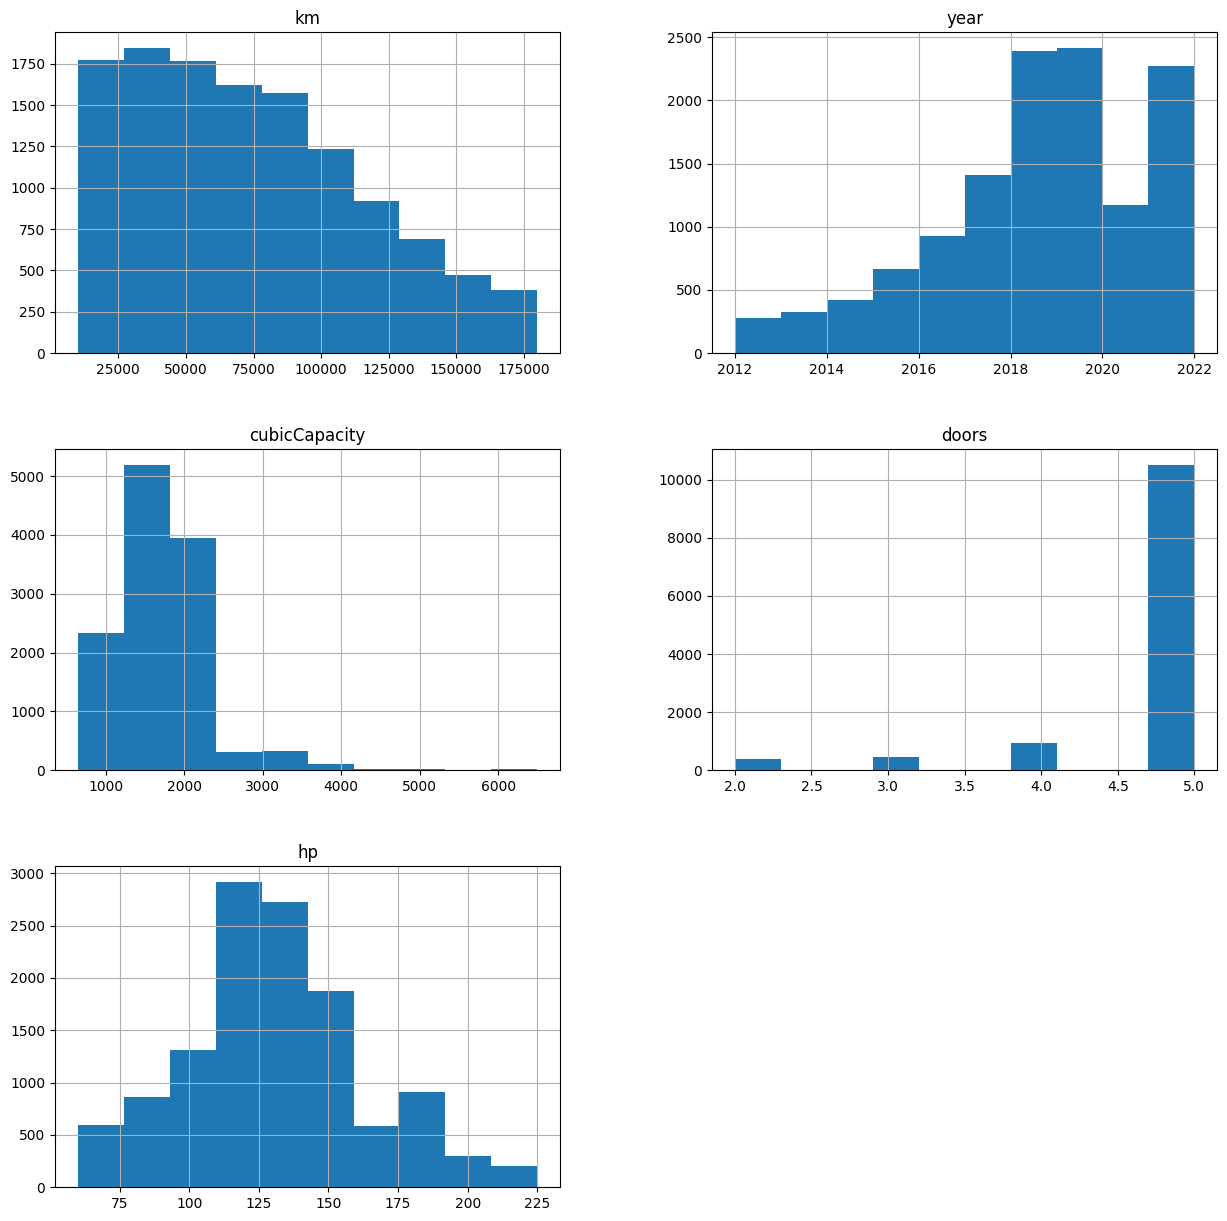

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data2[campos_numericos].hist(ax=plt.figure(figsize=(15,15)).gca())

<ipython-input-74-d589ac520d8b>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data2.corr(), cmap='BrBG', annot=True)


<Axes: >

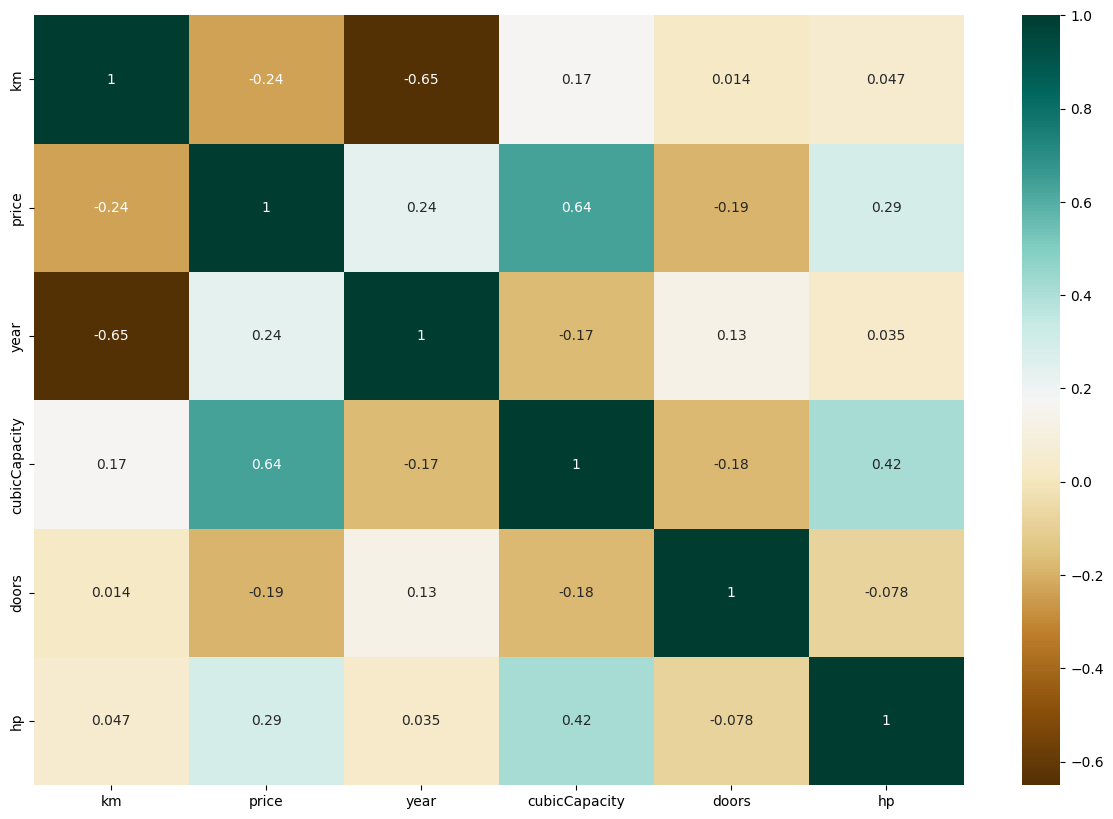

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(data2.corr(), cmap='BrBG', annot=True)

<Axes: xlabel='transmissionType', ylabel='price'>

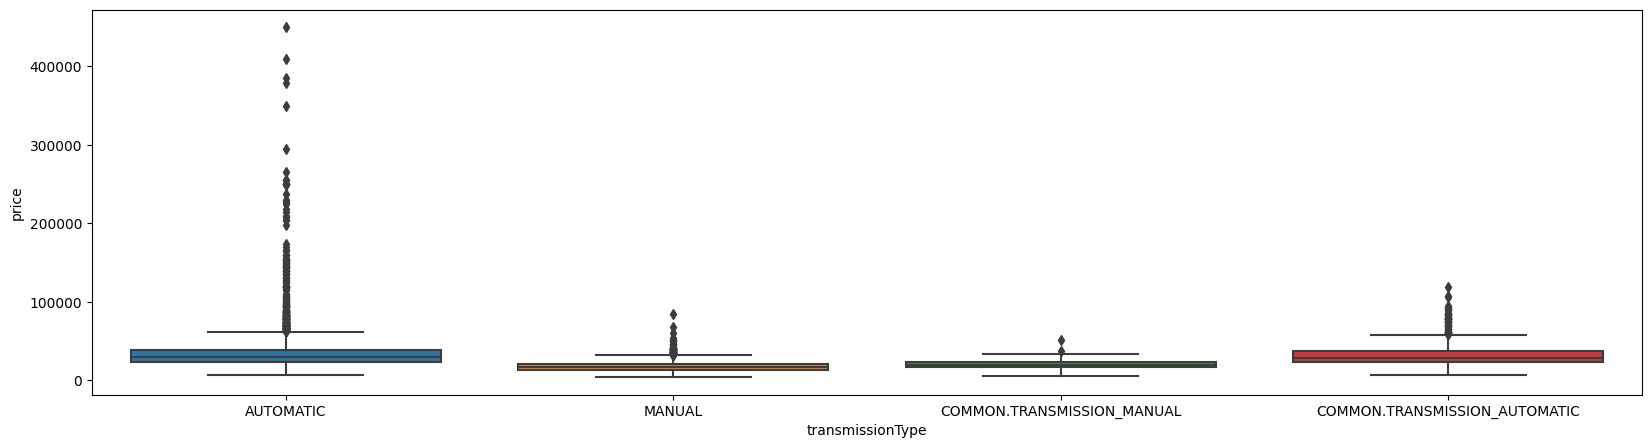

In [ ]:
plt.figure(figsize=(20,5))
sns.boxplot(x='transmissionType', y='price', data=data2) # etc.

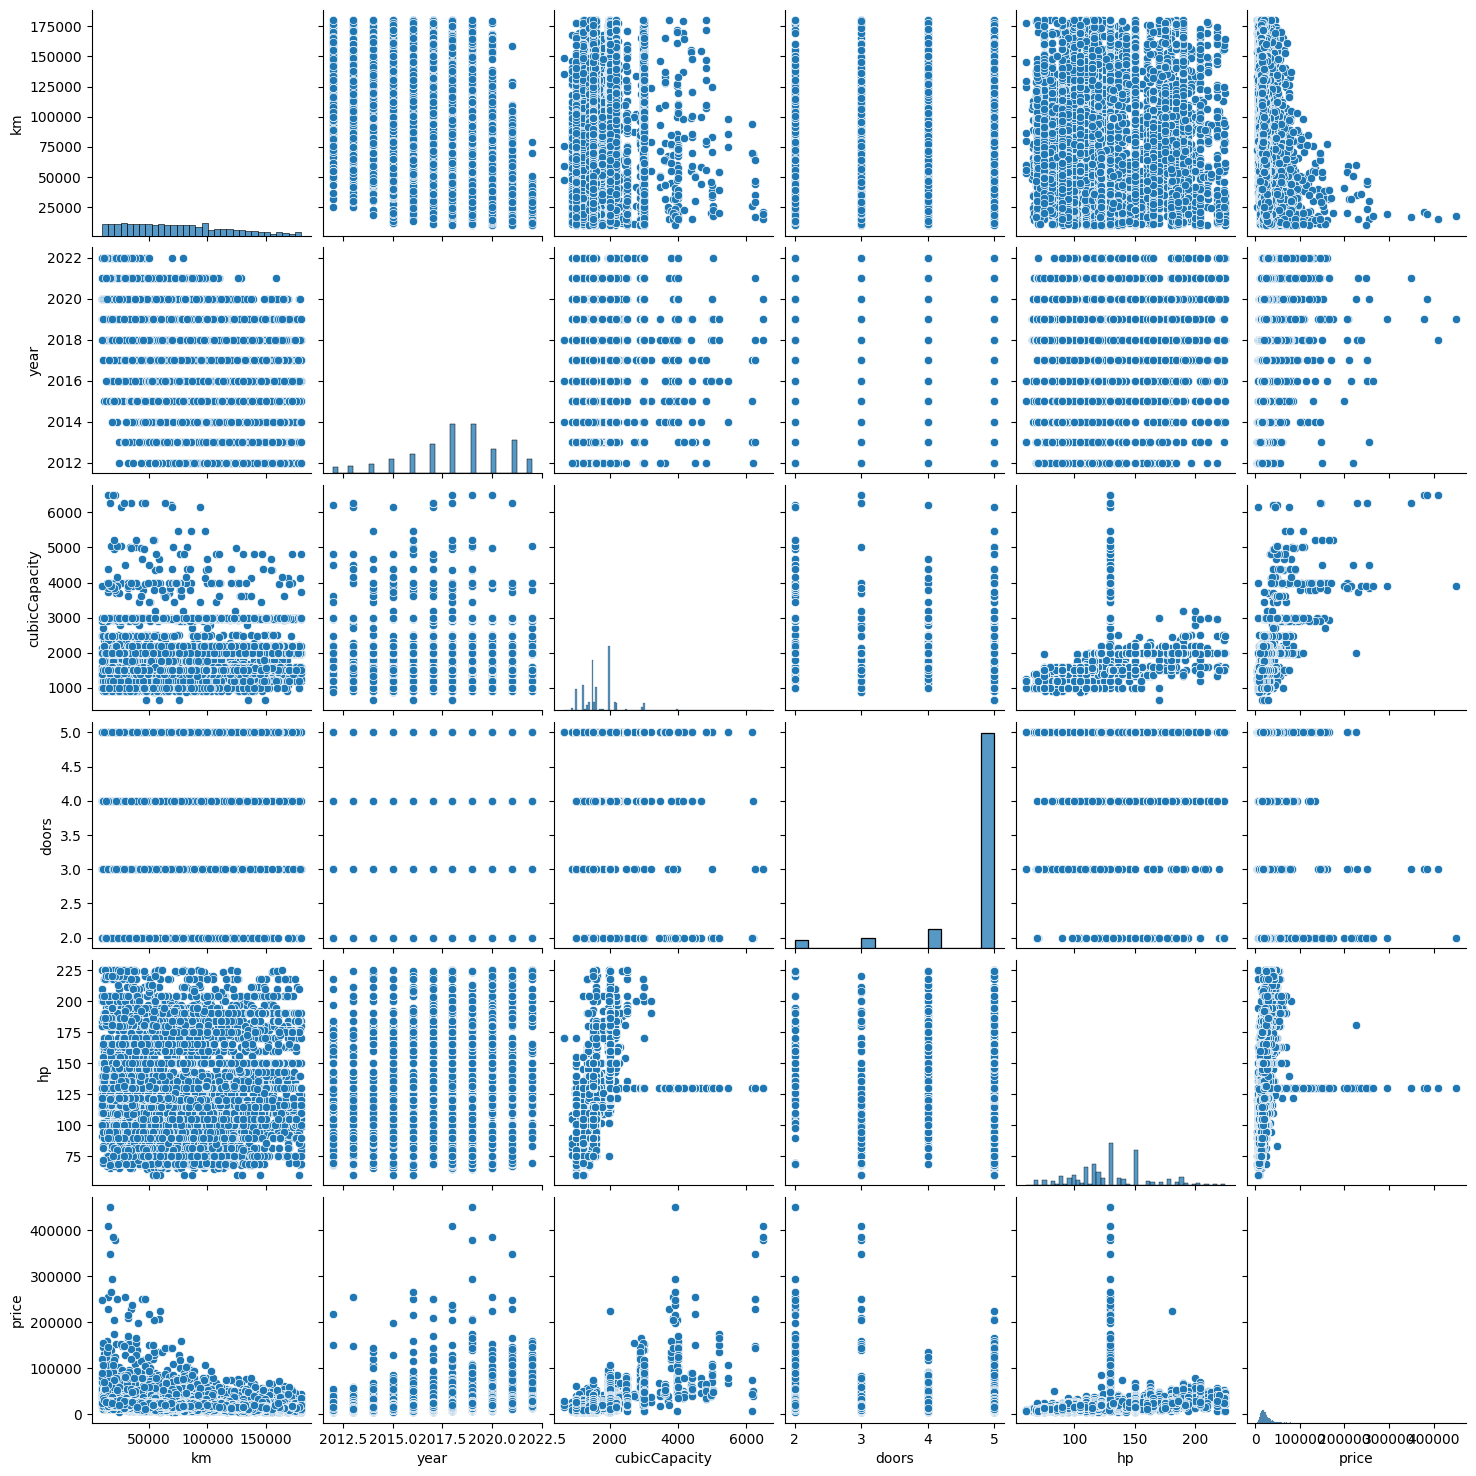

In [ ]:
sns.pairplot(data2[campos_numericos + [target]])

In [ ]:
used_features = all_feature_names + [target]

In [ ]:
used_features

['km',
 'year',
 'cubicCapacity',
 'doors',
 'hp',
 'color',
 'fuelType',
 'make',
 'model',
 'province',
 'transmissionType',
 'seller_type',
 'bodyType',
 'price']

In [ ]:
#@title Separar datos entre datos de entrada y etiquetas (resultados)

# Obtenemos la columna price
data_price= data2['price']

# Eliminamos la columna price del dataframe
data2 = data2.drop('price',axis=1)
     

In [ ]:
data_price[:10]

0    13990.0
1    68000.0
2    36900.0
3    33500.0
4    16500.0
5    18900.0
6    15990.0
7    23200.0
8    17500.0
9    22900.0
Name: price, dtype: float64

In [ ]:
print(data2[:10])

   color  fuelType        km        make      model    province  \
0  WHITE    Diésel  180000.0  VOLKSWAGEN       Golf   Guipúzcoa   
1  WHITE    Diésel   34000.0  VOLKSWAGEN   Multivan    A Coruña   
2    RED    Diésel   70000.0  VOLKSWAGEN  Caravelle    Asturias   
3   GRAY    Diésel   66855.0  VOLKSWAGEN     Tiguan      Madrid   
4  WHITE  Gasolina   89000.0  VOLKSWAGEN       Polo   Barcelona   
5   GRAY    Diésel   76000.0  VOLKSWAGEN     Passat      Toledo   
6   GRAY    Diésel   85341.0  VOLKSWAGEN       Golf     Sevilla   
7   BLUE   Híbrido   64990.0  VOLKSWAGEN       Golf      Madrid   
8   BLUE    Diésel  115000.0  VOLKSWAGEN     Passat      Madrid   
9   GRAY    Diésel   49500.0  VOLKSWAGEN     Passat  Las Palmas   

  transmissionType    year  seller_type  bodyType  cubicCapacity  doors     hp  
0        AUTOMATIC  2016.0   particular     SEDAN         1598.0    5.0  110.0  
1           MANUAL  2020.0   particular   MINIVAN         1968.0    5.0  150.0  
2        AUTOMATIC 

In [ ]:
data2[9:10].to_dict(orient='records')

[{'color': 'GRAY',
  'fuelType': 'Diésel',
  'km': 49500.0,
  'make': 'VOLKSWAGEN',
  'model': 'Passat',
  'province': 'Las Palmas',
  'transmissionType': 'AUTOMATIC',
  'year': 2017.0,
  'seller_type': 'profesional',
  'bodyType': 'FAMILIAR',
  'cubicCapacity': 1968.0,
  'doors': 5.0,
  'hp': 150.0}]

In [ ]:
# Iterar a través de cada columna
col_categoricas = []
for column in data2.columns:
    # Si la columna es categórica, imprimir los valores únicos
    if data2[column].dtype in ['object', 'category', 'bool']:
        print(f'Valores únicos de la columna "{column}":')
        print(data2[column].unique())
        col_categoricas.append(column)
     

In [ ]:
col_categoricas

['color',
 'fuelType',
 'make',
 'model',
 'province',
 'transmissionType',
 'seller_type',
 'bodyType']

In [ ]:
data2.dtypes

color                object
fuelType             object
km                  float64
make                 object
model                object
province             object
transmissionType     object
year                float64
seller_type          object
bodyType             object
cubicCapacity       float64
doors               float64
hp                  float64
dtype: object

In [ ]:
features = list(data2)

target = 'price'

numeric_features = data2._get_numeric_data().columns.tolist()
categorical_features = list(set(features) - set(numeric_features))

#numeric_features.remove(target)

all_features = numeric_features + categorical_features

In [ ]:
print(features)
print(numeric_features)
print(categorical_features)
print(all_features)
print(target)

['color', 'fuelType', 'km', 'make', 'model', 'province', 'transmissionType', 'year', 'seller_type', 'bodyType', 'cubicCapacity', 'doors', 'hp']
['km', 'year', 'cubicCapacity', 'doors', 'hp']
['seller_type', 'fuelType', 'make', 'transmissionType', 'color', 'province', 'model', 'bodyType']
['km', 'year', 'cubicCapacity', 'doors', 'hp', 'seller_type', 'fuelType', 'make', 'transmissionType', 'color', 'province', 'model', 'bodyType']
price


In [ ]:
x_train,x_test,y_train, y_test = train_test_split(data2, data_price, random_state=1, train_size=0.75)

In [ ]:
x_test[:1]

,color,fuelType,km,make,model,province,transmissionType,year,seller_type,bodyType,cubicCapacity,doors,hp
18,GRAY,Gasolina,45570.0,HONDA,Civic,Madrid,MANUAL,2019.0,profesional,SEDAN,988.0,5.0,129.0


In [ ]:
#las filas se convierten a formato de diccionario
train_dict = x_train[all_feature_names].to_dict(orient='records')
test_dict = x_test[all_feature_names].to_dict(orient='records')

In [ ]:
test_dict[:1]

[{'km': 45570.0,
  'year': 2019.0,
  'cubicCapacity': 988.0,
  'doors': 5.0,
  'hp': 129.0,
  'color': 'GRAY',
  'fuelType': 'Gasolina',
  'make': 'HONDA',
  'model': 'Civic',
  'province': 'Madrid',
  'transmissionType': 'MANUAL',
  'seller_type': 'profesional',
  'bodyType': 'SEDAN'}]

In [ ]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse = False)
dv.fit(data2.to_dict(orient='records'))
X_train = dv.transform(train_dict)
X_train[0]

array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       1.0000e+00, 0.0000e+00, 1.1990e+03, 5.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
       0.0000e+00, 1.1000e+02, 4.1956e+04, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e

In [ ]:
X_train.shape[1]

544

In [ ]:
X_test = dv.transform(test_dict)
X_test[0]

array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       9.880e+02, 5.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       1.000e+00, 0.000e+00, 0.000e+00, 1.290e+02, 4.557e+04, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 

In [ ]:
dv.get_feature_names_out()

array(['bodyType=4X4', 'bodyType=4x4 SUV', 'bodyType=4x4 suv',
       'bodyType=Berlina', 'bodyType=CABRIO', 'bodyType=COUPE',
       'bodyType=Cabrio', 'bodyType=Coupe', 'bodyType=FAMILIAR',
       'bodyType=Familiar', 'bodyType=MINIVAN', 'bodyType=PICK_UP',
       'bodyType=SEDAN', 'bodyType=berlina', 'bodyType=cabrio',
       'bodyType=coupe', 'bodyType=familiar', 'bodyType=monovolumen',
       'color=BEIGE', 'color=BLACK', 'color=BLUE', 'color=BROWN',
       'color=COMMON.COLOR_BEIGE', 'color=COMMON.COLOR_BLACK',
       'color=COMMON.COLOR_BLUE', 'color=COMMON.COLOR_BROWN',
       'color=COMMON.COLOR_GARNET', 'color=COMMON.COLOR_GRAY',
       'color=COMMON.COLOR_GREEN', 'color=COMMON.COLOR_ORANGE',
       'color=COMMON.COLOR_RED', 'color=COMMON.COLOR_WHITE',
       'color=COMMON.COLOR_YELLOW', 'color=GARNET', 'color=GRAY',
       'color=GREEN', 'color=ORANGE', 'color=PINK', 'color=PURPLE',
       'color=RED', 'color=WHITE', 'color=YELLOW', 'cubicCapacity',
       'doors', 'fuelType

#CREACIÓN Y ENTRENAMIENTO RED NEURONAL

In [ ]:
# implementa una red neuronal para realizar las mismas predicciones
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt

# Definimos el modelo de Keras
model = Sequential()
input_shape = len(X_train[0])
print('Numero de entradas:',input_shape)

model.add(Dense(X_train.shape[1], input_shape=(input_shape,), activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(X_train.shape[1]*2, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='linear', kernel_initializer='glorot_uniform'))

model.summary()
     

Numero de entradas: 544
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 544)               296480    
                                                                 
 dense_1 (Dense)             (None, 1088)              592960    
                                                                 
 dense_2 (Dense)             (None, 1)                 1089      
                                                                 
Total params: 890,529
Trainable params: 890,529
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#@title Compilamos el modelo y definimos los callbacks para evitar el sobreentrenamiento
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
import math

# Definir el optimizador
optimizer = Adam(learning_rate=0.01)

# Compilar el modelo
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Definir early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=0)

# Definir reducción del learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, min_lr=0.001, mode='min', verbose=0)

batch_size=int(math.sqrt(len(X_train)))
print("batch_size:",batch_size)

# Entrenar el modelo con reducción del learning rate
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5000, batch_size=batch_size, callbacks=[early_stop,reduce_lr], use_multiprocessing=True)

batch_size: 95
Epoch 1/5000
97/97 [==============================] - 4s 5ms/step - loss: 956075200.0000 - val_loss: 215371024.0000 - lr: 0.0100
Epoch 2/5000
97/97 [==============================] - 0s 3ms/step - loss: 149588176.0000 - val_loss: 157913760.0000 - lr: 0.0100
Epoch 3/5000
97/97 [==============================] - 0s 3ms/step - loss: 149661056.0000 - val_loss: 159895392.0000 - lr: 0.0100
Epoch 4/5000
97/97 [==============================] - 0s 3ms/step - loss: 138152560.0000 - val_loss: 135996000.0000 - lr: 0.0100
Epoch 5/5000
97/97 [==============================] - 0s 3ms/step - loss: 136896224.0000 - val_loss: 137086608.0000 - lr: 0.0100
Epoch 6/5000
97/97 [==============================] - 0s 3ms/step - loss: 137665984.0000 - val_loss: 136573424.0000 - lr: 0.0100
Epoch 7/5000
97/97 [==============================] - 0s 3ms/step - loss: 131353616.0000 - val_loss: 147026448.0000 - lr: 0.0100
Epoch 8/5000
97/97 [==============================] - 0s 3ms/step - loss: 13402425

In [ ]:
# Evaluamos el modelo en los datos de entrenamiento
mse = model.evaluate(X_test, y_test)
print('Error cuadrático medio (MSE): %.2f' % (mse))

96/96 [==============================] - 0s 2ms/step - loss: 108070584.0000
Error cuadrático medio (MSE): 108070584.00


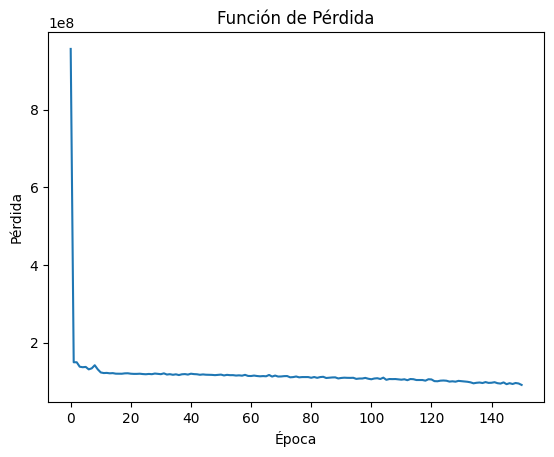

In [ ]:
# Graficar la evolución de la función de pérdida
plt.plot(history.history['loss'])
plt.title('Función de Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.show()

In [ ]:
test_data = {'color': 'BLUE', 'fueltype': 'Diésel', 'km': '34798', 'make': 'AUDI', 'model': 'A3', 'province': 'Almería', 'transmissiontype': 'AUTOMATIC', 'year': '2017', 'seller_type': 'profesional', 'bodytype': 'Berlina', 'cubiccapacity': '1598', 'doors': '5', 'hp': '116'}
test_data = dv.transform([dict(test_data)])
model.predict(test_data)

1/1 [==============================] - 0s 264ms/step


array([[921.04785]], dtype=float32)

96/96 [==============================] - 0s 1ms/step


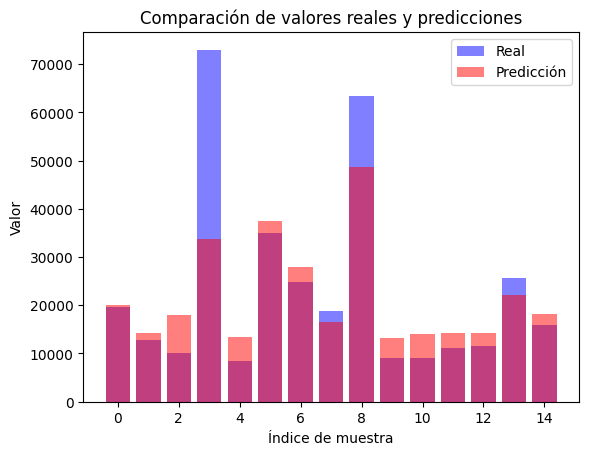

In [ ]:
y_pred = model.predict(X_test)
import numpy as np

# Crear un array de índices para los datos de prueba
indices = np.arange(15)

# Crear un gráfico de barras comparando los valores reales con las predicciones
plt.bar(indices, y_test[:15], color='b', alpha=0.5, label='Real')
plt.bar(indices, y_pred.flatten()[:15], color='r', alpha=0.5, label='Predicción')
plt.title('Comparación de valores reales y predicciones')
plt.xlabel('Índice de muestra')
plt.ylabel('Valor')
plt.legend()
plt.show()

In [ ]:
X_test[:1]

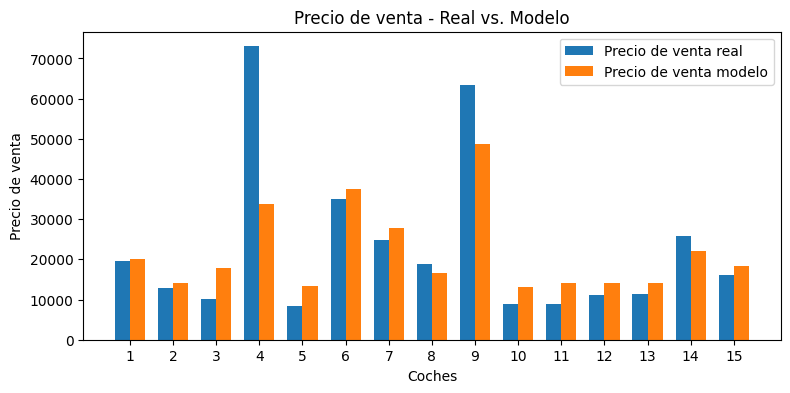

In [ ]:
ind = np.arange(15)
width = 0.35

plt.figure(figsize=(9,4))
plt.bar(ind, y_test[:15], width, label='Precio de venta real')
plt.bar(ind+width, y_pred.flatten()[:15], width, label='Precio de venta modelo')

plt.xticks(ind+width/2, np.arange(1, 16))
plt.legend(loc='best')

plt.xlabel('Coches')
plt.ylabel('Precio de venta')
plt.title('Precio de venta - Real vs. Modelo')

plt.show()

In [ ]:
import pickle
with open('dict_vectorizer_coches_net.pck', 'wb') as f:
  pickle.dump((dv), f)
model.save('modelo_keras_coches_net.hdf5')

In [ ]:
import tensorflow as tf
with open('dict_vectorizer_coches_net.pck', 'rb') as f:
  dv_read = pickle.load(f)
model_read = tf.keras.models.load_model('modelo_keras_coches_net.hdf5')

In [ ]:
dv_read

DictVectorizer(sparse=False)

In [ ]:
model_read

In [ ]:
#Comprimimos el modelo hdf5 y el pck en un zip para descargar en drive y poder usarlo
from google.colab import files
import zipfile
files_to_compress = ['dict_vectorizer_coches_net.pck','modelo_keras_coches_net.hdf5']
with zipfile.ZipFile('model_with_dict_vectorizer_coches_net.zip', 'w') as zip:
  for file in files_to_compress:
    zip.write(file)

files.download('model_with_dict_vectorizer_coches_net.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>